A transformer model handles variable-sized input using stacks of self-attention layers, and thus

* It makes no assumption about the temporal/spatial relationships across the data.
* Distant items can affect each other's output without passing through many RNN-steps.
* It can learn long-range dependencies.



In [2]:
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow_datasets as tfds
import numpy as np

import time
import matplotlib.pyplot as plt

In [3]:
print(tf.__version__)

2.0.0-dev20190415


# Preparing dataset

In [4]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

In [5]:
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), 
    target_vocab_size=2**13)

In [6]:
tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples),
    target_vocab_size=2**13)

In [7]:
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_en.encode(sample_string)
print('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string: Transformer is awesome.


In [8]:
tokenized_string

[7915, 1248, 7946, 7194, 13, 2799, 7877]

In [9]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [10]:
def encode(lang1, lang2):
    lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(lang1.numpy()) \
        + [tokenizer_pt.vocab_size+1]
        
    lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(lang2.numpy()) \
        + [tokenizer_en.vocab_size+1]
        
    return lang1, lang2

In [11]:
MAX_LENGTH = 40

def filter_max_length(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length,
                          tf.size(y) <= max_length)

In [12]:
def tf_encode(pt, en):
    return tf.py_function(encode, [pt, en], [tf.int64, tf.int64])

In [13]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)

In [14]:
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(
    BATCH_SIZE, padded_shapes=([-1], [-1]))
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [15]:
val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(
    BATCH_SIZE, padded_shapes=([-1], [-1]))

In [16]:
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

W0603 11:02:22.471614 140058849949440 backprop.py:820] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0603 11:02:22.474171 140058849949440 backprop.py:820] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0603 11:02:22.476275 140059370034944 backprop.py:820] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0603 11:02:22.477565 140059370034944 backprop.py:820] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0603 11:02:22.479727 140058849949440 backprop.py:820] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string


(<tf.Tensor: id=311410, shape=(64, 40), dtype=int64, numpy=
 array([[8214, 1259,    5, ...,    0,    0,    0],
        [8214,  299,   13, ...,    0,    0,    0],
        [8214,   59,    8, ...,    0,    0,    0],
        ...,
        [8214,   95,    3, ...,    0,    0,    0],
        [8214, 5157,    1, ...,    0,    0,    0],
        [8214, 4479, 7990, ...,    0,    0,    0]])>,
 <tf.Tensor: id=311411, shape=(64, 40), dtype=int64, numpy=
 array([[8087,   18,   12, ...,    0,    0,    0],
        [8087,  634,   30, ...,    0,    0,    0],
        [8087,   16,   13, ...,    0,    0,    0],
        ...,
        [8087,   12,   20, ...,    0,    0,    0],
        [8087,   17, 4981, ...,    0,    0,    0],
        [8087,   12, 5453, ...,    0,    0,    0]])>)

In [26]:
pt_batch[0:2]

<tf.Tensor: id=311454, shape=(2, 40), dtype=int64, numpy=
array([[8214, 1259,    5,   63, 5284,   50,  277,    2, 8215,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [8214,  299,   13,  803, 6422,   33, 5306,   40, 1236,   17, 4347,
        1189,   17, 1784, 1412, 7144,  829, 8215,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0]])>

In [27]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [36]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    
    sines = np.sin(angle_rads[:, 0::2])
    cosines = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = np.concatenate([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

In [37]:
pos_encoding = positional_encoding(50, 512)
print(pos_encoding.shape)

(1, 50, 512)


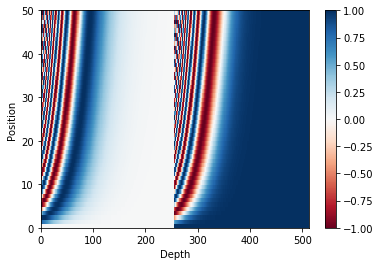

In [38]:
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Masking

In [49]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    
    return seq[:, tf.newaxis, tf.newaxis, :]

In [50]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: id=311470, shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [61]:
tf.linalg.band_part(tf.ones((4, 4)), -1, 0)

<tf.Tensor: id=311529, shape=(4, 4), dtype=float32, numpy=
array([[1., 0., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 1.]], dtype=float32)>

In [62]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones([size, size]), -1, 0)
    return mask

In [66]:
create_look_ahead_mask(5)

<tf.Tensor: id=311555, shape=(5, 5), dtype=float32, numpy=
array([[0., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.]], dtype=float32)>

In [74]:
a = tf.random.uniform([2, 3, 5])
b = tf.random.uniform([2, 4, 5])
tf.matmul(a, b, transpose_b=True)

<tf.Tensor: id=311661, shape=(2, 3, 4), dtype=float32, numpy=
array([[[2.2463179 , 1.0674183 , 1.323744  , 1.0721802 ],
        [2.1103451 , 1.276124  , 1.1072143 , 1.2956295 ],
        [2.0462158 , 1.4930547 , 1.0640979 , 1.3854487 ]],

       [[1.4006871 , 1.3033803 , 1.6887407 , 0.8317926 ],
        [1.0313916 , 1.1334199 , 1.8177315 , 0.69784236],
        [1.6147704 , 1.243691  , 1.8701763 , 1.0127685 ]]], dtype=float32)>

In [193]:
def create_masks(x, y):
    encoder_padding_mask = create_padding_mask(x)
    decoder_padding_mask = create_padding_mask(x)
    look_ahead_mask = create_look_ahead_mask(y.shape[1])
    decoder_padding_mask2 = create_padding_mask(y)
    combined_mask = tf.maximum(decoder_padding_mask2, look_ahead_mask)
    
    return encoder_padding_mask, combined_mask, decoder_padding_mask

In [78]:
def scaled_dot_product_attention(q, k, v, mask):
    """
    Input:
    q (batch, num_heads, seq_len1, depth1)
    k (batch, num_heads, seq_len2, depth1)
    v (batch, num_heads, seq_len2, depth2)
    
    The dimension of batch, num_heads can be empty.
    
    mask (seq_len1, seq_len2)
    
    Output:
    output (batch, num_heads, seq_len1, depth2)
    attention_weights (batch, num_heads, seq_len1, seq_len2)
    """
    ## (batch, num_heads, seq_len1, seq_len2)
    qk = tf.matmul(q, k, transpose_b=True)
    
    dk = tf.cast(k.shape[-1], tf.float32)
    ## (batch, num_heads, seq_len1, seq_len2)
    scaled_attention_logits = qk / tf.sqrt(dk)
    
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    
    ## (batch, num_heads, seq_len1, seq_len2)
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    
    ## (batch, num_heads, seq_len1, depth2)
    output = tf.matmul(attention_weights, v)
    
    return output, attention_weights

In [81]:
q = tf.random.uniform([1, 2, 10])
k = tf.random.uniform([1, 3, 10])
v = tf.random.uniform([1, 3, 5])

output, attention_weights = scaled_dot_product_attention(q, k, v, None)

In [85]:
print(output.shape)
print(attention_weights.shape)

(1, 2, 5)
(1, 2, 3)


In [96]:
class MultiHeadAttention(tfk.layers.Layer):
    def __init__(self, model_depth, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.model_depth = model_depth
        
        assert self.model_depth % self.num_heads == 0
        
        self.depth = model_depth // self.num_heads
        
        self.q2q = tfk.layers.Dense(self.model_depth)
        self.k2k = tfk.layers.Dense(self.model_depth)
        self.v2v = tfk.layers.Dense(self.model_depth)
        
        self.o2o = tfk.layers.Dense(self.model_depth)
        
    def split_heads(self, x):
        """
        Input:
        x (batch, seq_len, model_depth)
        
        Output:
        o (batch, num_heads, seq_len, depth)
        """
        o = tf.reshape(x, [x.shape[0], -1, self.num_heads, self.depth])
        return tf.transpose(o, perm=[0, 2, 1, 3])
    
    def call(self, q, k, v, mask):
        """
        Input:
        q (batch, seq_len1, embedding_size_q)
        k (batch, seq_len2, embedding_size_k)
        v (batch, seq_len2, embedding_size_v)
        mask (seq_len1, seq_len2)
        
        Output:
        o (batch, seq_len1, model_depth)
        attention_weigths (batch, num_heads, seq_len1, seq_len2)
        """
        q = self.q2q(q) # (batch, seq_len1, model_depth)
        k = self.k2k(k) # (batch, seq_len2, model_depth)
        v = self.v2v(v) # (batch, seq_len2, model_depth)
        
        q = self.split_heads(q) # (batch, num_heads, seq_len1, depth)
        k = self.split_heads(k) # (batch, num_heads, seq_len2, depth)
        v = self.split_heads(v) # (batch, num_heads, seq_len2, depth)
        
        ## (batch, num_heads, seq_len1, depth), (batch, num_heads, seq_len1, seq_len2)
        o, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        
        ## (batch, seq_len1, num_heads, depth)
        o = tf.transpose(o, perm=[0, 2, 1, 3])
        ## (batch, seq_len1, model_depth)
        o = tf.reshape(o, [o.shape[0], -1, self.model_depth])
        o = self.o2o(o)
        return o, attention_weights

In [97]:
mha = MultiHeadAttention(model_depth=512, num_heads=8)

In [101]:
y = tf.random.uniform([1, 60, 512]) # (batch, seq_len, model_depth)
out, attn = mha(y, y, y, mask=None)
print(out.shape)
print(attn.shape)

(1, 60, 512)
(1, 8, 60, 60)


In [132]:
y = tf.random.uniform([1, 60, 512])
x = tf.random.uniform([1, 30, 512])
out, attn = mha(y, x, x, mask=None)
print(out.shape)
print(attn.shape)

(1, 60, 512)
(1, 8, 60, 30)


## Pointwise feed forward network

In [102]:
def pointwise_feed_forward_network(model_depth, hidden_dim):
    return tfk.Sequential([
        tfk.layers.Dense(hidden_dim, activation='relu'), 
        tfk.layers.Dense(model_depth)
    ])

In [105]:
ffn = pointwise_feed_forward_network(512, 2048)
x = tf.random.uniform([64, 50, 256]) # (batch, seq_len, *)
ffn(x).shape

TensorShape([64, 50, 512])

## Encoder and decoder

In [110]:
class EncoderLayer(tfk.layers.Layer):
    def __init__(self, model_depth, num_heads, ffn_hidden_size, dropout_rate=0.1):
        super(EncoderLayer, self).__init__()
        
        self.mha = MultiHeadAttention(model_depth, num_heads)
        self.ffn = pointwise_feed_forward_network(model_depth, ffn_hidden_size)
        
        self.layernorm1 = tfk.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tfk.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tfk.layers.Dropout(dropout_rate)
        self.dropout2 = tfk.layers.Dropout(dropout_rate)
        
    def call(self, x, training, mask):
        """
        Input:
        x (batch, seq_len2, model_depth)
        training: True or False
        mask (seq_len2, seq_len2)
        
        Output:
        o2 (batch, seq_len2, model_depth)
        """
        ## (batch, seq_len2, model_depth)
        o1, _ = self.mha(x, x, x, mask)
        o1 = self.dropout1(o1, training=training)
        o1 = self.layernorm1(x + o1)
        
        ## (batch, seq_len2, model_depth)
        o2 = self.ffn(o1)
        o2 = self.dropout2(o2, training=training)
        o2 = self.layernorm2(o1 + o2)
        
        return o2

In [111]:
encoder_layer = EncoderLayer(512, 8, 2048)

In [115]:
encoder_output = encoder_layer(tf.random.uniform([64, 43, 512]), False, None)
encoder_output.shape

TensorShape([64, 43, 512])

In [113]:
class DecoderLayer(tfk.layers.Layer):
    def __init__(self, model_depth, num_heads, ffn_hidden_size, dropout_rate=0.1):
        super(DecoderLayer, self).__init__()
        
        self.mha1 = MultiHeadAttention(model_depth, num_heads)
        self.mha2 = MultiHeadAttention(model_depth, num_heads)
        
        self.ffn = pointwise_feed_forward_network(model_depth, ffn_hidden_size)
        
        self.layernorm1 = tfk.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tfk.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tfk.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tfk.layers.Dropout(dropout_rate)
        self.dropout2 = tfk.layers.Dropout(dropout_rate)
        self.dropout3 = tfk.layers.Dropout(dropout_rate)
        
    def call(self, x, encoder_output, training, look_ahead_mask,
             padding_mask):
        """
        Input:
        x (batch, seq_len1, model_depth): target
        encoder_output (batch, seq_len2, model_depth): source
        look_ahead_mask (seq_len1, seq_len1): target mask
        padding_mask (seq_len1, seq_len2): source mask
        
        Output:
        o3 (batch, seq_len1, model_depth)
        attn_weights1 (batch, num_heads, seq_len1, seq_len1)
        attn_weights2 (batch, num_heads, seq_len1, seq_len2)
        """
        ## o1 (batch, seq_len1, model_depth)
        o1, attn_weights1 = self.mha1(x, x, x, look_ahead_mask)
        o1 = self.dropout1(o1, training=training)
        o1 = self.layernorm1(o1 + x)
        
        ## o2 (batch, seq_len1, model_depth)
        o2, attn_weights2 = self.mha2(o1, encoder_output, encoder_output, padding_mask)
        o2 = self.dropout2(o2, training=training)
        o2 = self.layernorm2(o2 + o1)
        
        ## o3 (batch, seq_len1, model_depth)
        o3 = self.ffn(o2)
        o3 = self.dropout3(o3, training=training)
        o3 = self.layernorm3(o3 + o2)
        
        return o3, attn_weights1, attn_weights2

In [114]:
decoder_layer = DecoderLayer(512, 8, 2048)

In [117]:
decoder_output, _, _ = decoder_layer(tf.random.uniform([64, 50, 512]), encoder_output, 
                                     False, None, None)
decoder_output.shape

TensorShape([64, 50, 512])

In [129]:
class Encoder(tfk.layers.Layer):
    def __init__(self, num_layers, model_depth, num_heads, ffn_hidden_size,
                 input_vocab_size, dropout_rate=0.1, max_length=MAX_LENGTH):
        super(Encoder, self).__init__()
        
        self.model_depth = model_depth
        self.num_layers = num_layers
        
        self.embedding = tfk.layers.Embedding(input_vocab_size, self.model_depth)
        self.pos_encoding = positional_encoding(max_length+5, self.model_depth)
        
        self.encoder_layers = [EncoderLayer(model_depth, num_heads, ffn_hidden_size, 
                                            dropout_rate) for _ in range(num_layers)]
        self.dropout = tfk.layers.Dropout(dropout_rate)
        
    def call(self, x, training, mask):
        """
        Input:
        x (batch, seq_len2)
        training: True or False
        mask (seq_len2, seq_len2)
        
        Output:
        o (batch, seq_len2, model_depth)
        """
        seq_len = x.shape[1]
        
        o = self.embedding(x)
        o = o * tf.sqrt(self.model_depth * 1.0)
        o = o + self.pos_encoding[:, :seq_len, :]
        
        o = self.dropout(o, training=training)
        
        for i in range(self.num_layers):
            o = self.encoder_layers[i](o, training, mask)
            
        return o

In [130]:
encoder = Encoder(num_layers=2, model_depth=512, num_heads=8,
                  ffn_hidden_size=2048, input_vocab_size=8500)

In [131]:
encoder_output = encoder(tf.random.uniform([64, 30]), training=False,
                         mask=None)
encoder_output.shape

TensorShape([64, 30, 512])

In [136]:
class Decoder(tfk.layers.Layer):
    def __init__(self, num_layers, model_depth, num_heads, ffn_hidden_size,
                 target_vocab_size, dropout_rate=0.1, max_length=MAX_LENGTH):
        super(Decoder, self).__init__()
        
        self.model_depth = model_depth
        self.num_layers = num_layers
        
        self.embedding = tfk.layers.Embedding(target_vocab_size, self.model_depth)
        self.pos_encoding = positional_encoding(max_length+5, self.model_depth)
        
        self.decoder_layers = [DecoderLayer(model_depth, num_heads, ffn_hidden_size,
                                            dropout_rate) for _ in range(num_layers)]
        self.dropout = tfk.layers.Dropout(dropout_rate)
        
    def call(self, x, encoder_output, training, 
             look_ahead_mask, padding_mask):
        """
        Input:
        x (batch, seq_len1)
        encoder_output (batch, seq_len2, model_depth)
        training: True or False
        look_ahead_mask (seq_len1, seq_len1)
        padding_mask (seq_len1, seq_len2)
        
        o (batch, seq_len1, model_depth)
        """
        
        seq_len = x.shape[1]
        attention_weights = {}
        
        ## (batch, seq_len1, model_depth)
        o = self.embedding(x)
        o = o * tf.sqrt(tf.cast(self.model_depth, tf.float32))
        o = o + self.pos_encoding[:, :seq_len, :]
        o = self.dropout(o, training=training)
        
        for i in range(self.num_layers):
            o, block1, block2 = self.decoder_layers[i](o, encoder_output, training,
                                                       look_ahead_mask, padding_mask)
            
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
            
        return o, attention_weights

In [137]:
decoder = Decoder(num_layers=2, model_depth=512, num_heads=8,
                  ffn_hidden_size=2048, target_vocab_size=8000)

In [140]:
print(encoder_output.shape)
decoder_output, attn = decoder(tf.random.uniform([64, 26]), 
                               encoder_output=encoder_output,
                               training=False, look_ahead_mask=None, padding_mask=None)
print(decoder_output.shape)

(64, 30, 512)
(64, 26, 512)


In [151]:
class Transformer(tfk.Model):
    def __init__(self, num_layers, model_depth, num_heads, ffn_hidden_size,
                 input_vocab_size, target_vocab_size, dropout_rate=0.1):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder(num_layers, model_depth, num_heads, ffn_hidden_size,
                               input_vocab_size, dropout_rate)
        self.decoder = Decoder(num_layers, model_depth, num_heads, ffn_hidden_size,
                               target_vocab_size, dropout_rate)
        self.final_layer = tfk.layers.Dense(target_vocab_size)
        
    def call(self, x, y, training, encoder_padding_mask, look_ahead_mask,
             decoder_padding_mask):
        encoder_output = self.encoder(x, training, encoder_padding_mask)
        decoder_output, attention_weights = self.decoder(y, encoder_output, 
            training, look_ahead_mask, decoder_padding_mask)
        o = self.final_layer(decoder_output)
        
        return o, attention_weights

In [152]:
transformer = Transformer(num_layers=2, model_depth=512, num_heads=8, ffn_hidden_size=2048,
                          input_vocab_size=8500, target_vocab_size=8000)

In [170]:
x = tf.random.uniform([64, 32], maxval=8500, dtype=tf.int32)
y = tf.random.uniform([64, 26], maxval=8000, dtype=tf.int32)

o, _ = transformer(x, y, training=False,
                   encoder_padding_mask=None,
                   look_ahead_mask=None,
                   decoder_padding_mask=None)
o.shape

TensorShape([64, 26, 8000])

## Set hyperparameters

In [205]:
num_layers = 4
model_depth = 128
ffn_hidden_size = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2

dropout_rate = 0.1

EPOCHS = 20

## Optimizer

In [174]:
class CustomSchedule(tfk.optimizers.schedules.LearningRateSchedule):
    def __init__(self, model_depth, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.model_depth = tf.cast(model_depth, tf.float32)
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        a = tf.math.rsqrt(step)
        b = step * (self.warmup_steps ** -1.5)
        
        return tf.math.rsqrt(self.model_depth) * tf.math.minimum(a, b)

In [179]:
lr = CustomSchedule(model_depth)
optimizer = tfk.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

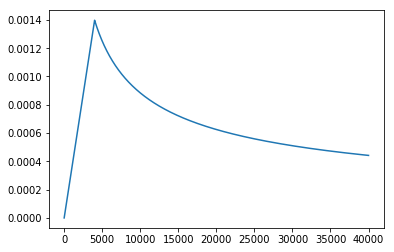

In [182]:
tmp_lr = CustomSchedule(model_depth)
plt.plot(tmp_lr(tf.range(40000, dtype=tf.float32)))

## Loss and metrics

In [262]:
loss_object = tfk.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(y, ŷ):
    mask = tf.math.logical_not(tf.math.equal(y, 0))
    loss = loss_object(y, ŷ)
    mask = tf.cast(mask, dtype=loss.dtype)
    loss = loss * mask
    return tf.reduce_mean(loss)

In [263]:
train_loss = tfk.metrics.Mean(name='train_loss')
train_accuracy = tfk.metrics.SparseCategoricalAccuracy(name='train_accuracy')

In [264]:
transformer = Transformer(num_layers, model_depth, num_heads, ffn_hidden_size,
                          input_vocab_size, target_vocab_size, dropout_rate)

In [265]:
checkpointpath = "/tmp/checkpoints/train"
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpointpath, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Latest checkpoint restored.")

In [266]:
#@tf.function
def train_step(x, y):
    y_i = y[:, :-1] # y input
    y_o = y[:, 1:] # y output
    
    encoder_padding_mask, look_ahead_mask, decoder_padding_mask = create_masks(x, y_i)
    
    with tf.GradientTape() as tape:
        ŷ, _ = transformer(x, y_i,
                           True, # training
                           encoder_padding_mask,
                           look_ahead_mask,
                           decoder_padding_mask)
        loss = loss_function(y_o, ŷ)
        
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    
    train_loss(loss)
    train_accuracy(y_o, ŷ)

In [267]:
for epoch in range(EPOCHS):
    start = time.time()
    
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    for (it, (x, y)) in enumerate(train_dataset):
        train_step(x, y)
        if it % 200 == 0:
            print('Epoch {} Iteration {} Loss {:.4f} Accuracy {:.4f}'.format(
                epoch+1, it, train_loss.result(), train_accuracy.result()))
    
    print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch+1,
                                                        train_loss.result(),
                                                        train_accuracy.result()))
    
    print('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Iteration 0 Loss 4.3648 Accuracy 0.0000
Epoch 1 Iteration 200 Loss 3.2593 Accuracy 0.0422
Epoch 1 Iteration 400 Loss 2.9967 Accuracy 0.0652
Epoch 1 Iteration 600 Loss 2.8093 Accuracy 0.0818
Epoch 1 Loss 2.7363 Accuracy 0.0881
Time taken for 1 epoch: 272.24140644073486 secs

Epoch 2 Iteration 0 Loss 2.3118 Accuracy 0.1283
Epoch 2 Iteration 200 Loss 2.2630 Accuracy 0.1325
Epoch 2 Iteration 400 Loss 2.2350 Accuracy 0.1367
Epoch 2 Iteration 600 Loss 2.1974 Accuracy 0.1400
Epoch 2 Loss 2.1777 Accuracy 0.1414
Time taken for 1 epoch: 268.45932030677795 secs

Epoch 3 Iteration 0 Loss 2.0783 Accuracy 0.1558
Epoch 3 Iteration 200 Loss 2.0438 Accuracy 0.1543
Epoch 3 Iteration 400 Loss 2.0173 Accuracy 0.1588
Epoch 3 Iteration 600 Loss 1.9815 Accuracy 0.1624
Epoch 3 Loss 1.9603 Accuracy 0.1645
Time taken for 1 epoch: 270.88839769363403 secs

Epoch 4 Iteration 0 Loss 1.8607 Accuracy 0.1830
Epoch 4 Iteration 200 Loss 1.8033 Accuracy 0.1831
Epoch 4 Iteration 400 Loss 1.7786 Accuracy 0.1879
Epo

## Evaluate

* The decoder starts with the `start token` as the input
* The decoder predicts the next word based on the previous words it predicted
* We concatenate the predicted word to the current input to be the input of next iteration

In [269]:
def evaluate (input_sentence):
    """
    input_sentence is a sentence to the encoder.
    """
    x = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(input_sentence)\
        + [tokenizer_pt.vocab_size + 1]
    x = tf.expand_dims(x, 0) # add batch dimension
    
    y = tf.expand_dims([tokenizer_en.vocab_size], 0) # (batch, seq_len)
    
    for i in range(MAX_LENGTH):
        encoder_padding_mask, look_ahead_mask, decoder_padding_mask = create_masks(x, y)
        
        predictions, attention_weights = transformer(x, 
                                                     y,
                                                     False,
                                                     encoder_padding_mask,
                                                     look_ahead_mask,
                                                     decoder_padding_mask)
        ## (batch, 1, vocab_size)
        last_prediction = predictions[:, -1:, :]
        ## (batch, 1)
        last_token = tf.cast(tf.argmax(last_prediction, axis=-1), tf.int32)
        
        ## reached the end token
        if tf.equal(last_token, tokenizer_en.vocab_size+1):
            return tf.squeeze(y, axis=0), attention_weights
        
        ## concatenate the last token to y 
        y = tf.concat([y, last_token], axis=-1)
        
    return tf.squeeze(y, axis=0), attention_weights

In [270]:
def translate(input_sentence, layer=None):
    y, attention_weights = evaluate(input_sentence)
    
    output_sentence = tokenizer_en.decode([i for i in y if i < tokenizer_en.vocab_size])
    
    print('Input: {}'.format(input_sentence))
    print('Translation: {}'.format(output_sentence))
    
    if layer is not None:
        plot_attention_weights(attention_weights, input_sentence, y, layer)

In [272]:
translate("este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")

Input: este é um problema que temos que resolver.
Translation: this is a problem that we have to be solved .
Real translation: this is a problem we have to solve .


In [273]:
translate("os meus vizinhos ouviram sobre esta ideia.")
print ("Real translation: and my neighboring homes heard about this idea .")

Input: os meus vizinhos ouviram sobre esta ideia.
Translation: my neighbors heard about this idea .
Real translation: and my neighboring homes heard about this idea .
